Face-tracing algorithm
=========================

Problem: given a set of lines, identify all closed regions (subshapes).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

Loads our helper module built for this exercise

In [2]:
import hestus
from importlib import reload

In [3]:
reload(hestus)

<module 'hestus' from '/Users/nemmen/Library/CloudStorage/Dropbox/codes/jupyter/projects/hestus-problem/hestus.py'>

In [4]:
import networkx as nx
import math

## Trial shapes

In [5]:
square = (
    ((1, 1), (1, 2)),
    ((1, 2), (2, 2)),
    ((2, 2), (2, 1)),
    ((2, 1), (1, 1)),
)

In [6]:
hourglass=( ((1, 1), (1, 2)),
((1, 2), (2, 1)),
((2, 1), (2, 2)),
((2, 2), (1, 1)), )

In [7]:
window= ( ((1, 1), (1, 2)),
((1, 2), (2, 2)),
((2, 2), (2, 1)),
((2, 1), (1, 1)),
((1.5, 1), (1.5, 2)),
((1, 1.5), (2, 1.5)), )

In [8]:
mystery=( ((1, 1), (1, 2)),
((1, 2), (1.8, 2)),
((1.8, 2), (1.8, 1)),
((1.8, 1), (1, 1)),
((1.2, 1), (1.2, 2)),
((1.6, 1), (1.6, 2)),
((1, 1.5), (1.6, 1.8)),
((1, 1.3), (1.8, 1.7)),
((1.2, 1.2), (1.8, 1.5)), )

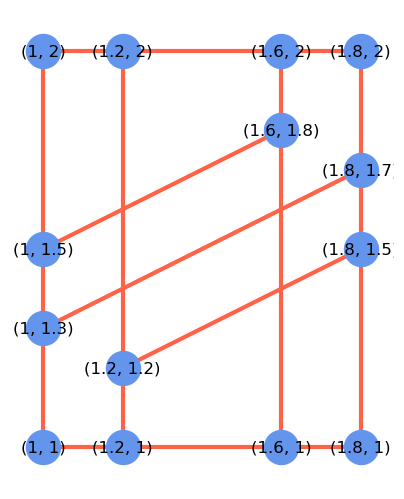

In [9]:
hestus.plot(mystery)

## Playing with graphs

create an undirected graph and load the edges

In [10]:
G = nx.Graph()
G.add_edges_from(mystery)

some basic operations

In [11]:
print(f"|V|={G.number_of_nodes()}, |E|={G.number_of_edges()}")

|V|=14, |E|=9


In [12]:
print("nodes:", G.nodes())
print("edges:", G.edges())

nodes: [(1, 1), (1, 2), (1.8, 2), (1.8, 1), (1.2, 1), (1.2, 2), (1.6, 1), (1.6, 2), (1, 1.5), (1.6, 1.8), (1, 1.3), (1.8, 1.7), (1.2, 1.2), (1.8, 1.5)]
edges: [((1, 1), (1, 2)), ((1, 1), (1.8, 1)), ((1, 2), (1.8, 2)), ((1.8, 2), (1.8, 1)), ((1.2, 1), (1.2, 2)), ((1.6, 1), (1.6, 2)), ((1, 1.5), (1.6, 1.8)), ((1, 1.3), (1.8, 1.7)), ((1.2, 1.2), (1.8, 1.5))]


### Basic operations on a node

In [13]:
print("degree of (1,1):", G.degree((1,1)))          

degree of (1,1): 2


Dict of neighbors of a node

In [14]:
G.adj[(1,1)]

AtlasView({(1, 2): {}, (1.8, 1): {}})

Edges connected to a given node

In [15]:
G.edges((1,1))

EdgeDataView([((1, 1), (1, 2)), ((1, 1), (1.8, 1))])

### Simple cycle detection

In [16]:
cycles=nx.cycle_basis(G)

In [17]:
print(cycles)

[[(1.8, 2), (1, 2), (1, 1), (1.8, 1)]]


In [18]:
print("contains cycle?", bool(nx.cycle_basis(G)))

contains cycle? True


## Algorithm outline

Our eyes immediately realize the intersections between lines and the geometrical "subshapes" they form, but the computer has no idea about them. We need to use geometry to teach the computer to identify these shapes. There are three basic steps.

1. Find intersections between lines‚úÖ
2. Establish new edges in addition to those of the original shape‚úÖ
3. Identify closed regions‚úÖ

Below I will break down steps 1 to 3.

## (1) Find intersections

### Find intersecting point between two lines

In [19]:
def find_intersection(l1, l2):
    """
    Return (xi, yi) where (xi, yi) is the intersection of the
    infinite lines through p1-p2 and p3-p4.
    Input: each point is a pair (x, y).
    """
    (x1, y1), (x2, y2) = l1
    (x3, y3), (x4, y4) = l2

    denom = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
    if denom == 0:            # parallel or coincident
        return None, None

    c1 = x1*y2 - y1*x2
    c2 = x3*y4 - y3*x4

    xi = (c1*(x3 - x4) - (x1 - x2)*c2) / denom
    yi = (c1*(y3 - y4) - (y1 - y2)*c2) / denom

    # parameters for the two segments
    t = ((x3 - x1)*(y3 - y4) - (y3 - y1)*(x3 - x4)) / denom
    u = ((x3 - x1)*(y1 - y2) - (y3 - y1)*(x1 - x2)) / denom

    return (xi, yi)

In [20]:
find_intersection(((1, 1), (1, 2)),((1.5, 1), (1.5, 2)))

(None, None)

In [21]:
find_intersection(((1, 1), (1, 2)),((1, 1.5), (2, 1.5)))

(1.0, 1.5)

### Find all intersections in graph

In [22]:
intersections=set()

for e in G.edges():
    for f in G.edges():
        # avoid the same vertex
        if e!=f:
            inter=find_intersection(e,f)
            if None not in inter:
                intersections.add(inter)

In [23]:
intersections

{(-1729382256910270.0, -864691128455134.0),
 (-6.938893903907227e-16, 1.0),
 (0.39999999999999936, 1.0),
 (0.7999999999999992, 1.0),
 (1.0, 1.0),
 (1.0, 1.1000000000000005),
 (1.0, 1.3000000000000003),
 (1.0, 1.5000000000000004),
 (1.0, 2.0),
 (1.2, 1.0),
 (1.2, 1.2000000000000006),
 (1.2, 1.4000000000000001),
 (1.2, 1.6000000000000005),
 (1.2, 2.0),
 (1.6, 1.4000000000000006),
 (1.6, 1.8000000000000005),
 (1.6000000000000003, 1.0),
 (1.6000000000000003, 1.6000000000000003),
 (1.6000000000000003, 2.0),
 (1.8, 1.0),
 (1.8, 1.7000000000000004),
 (1.8, 2.0),
 (1.8000000000000003, 1.5000000000000004),
 (1.8000000000000003, 1.9000000000000006),
 (1.9999999999999993, 2.0),
 (2.4, 2.0),
 (2.7999999999999994, 2.0),
 (1729382256910271.0, 864691128455136.0)}

In [24]:
len(intersections)

28

## (2) Establish new segments

Fully connected graph, with all possible connections between nodes

In [25]:
FG = nx.complete_graph(intersections)   # undirected by default

In [26]:
FG.number_of_edges()

378

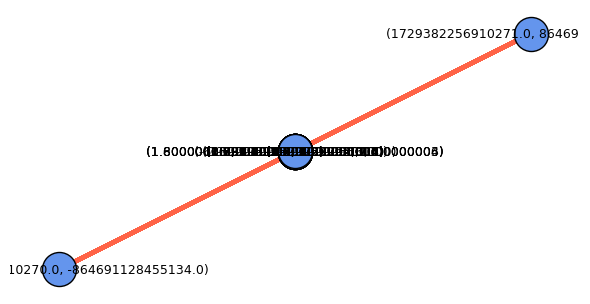

In [27]:
hestus.plot_graph(FG)

### Test parallel lines finder

Discard those that are not parallel to pre-existing lines

In [150]:
FG.edges()

EdgeView([((1.0, 2.0), (1.5, 1.0)), ((1.0, 2.0), (2.0, 1.0)), ((1.0, 2.0), (2.0, 1.5)), ((1.0, 2.0), (1.5, 1.5)), ((1.0, 2.0), (1.0, 1.5)), ((1.0, 2.0), (1.0, 1.0)), ((1.0, 2.0), (2.0, 2.0)), ((1.0, 2.0), (1.5, 2.0)), ((1.5, 1.0), (2.0, 1.0)), ((1.5, 1.0), (2.0, 1.5)), ((1.5, 1.0), (1.5, 1.5)), ((1.5, 1.0), (1.0, 1.5)), ((1.5, 1.0), (1.0, 1.0)), ((1.5, 1.0), (2.0, 2.0)), ((1.5, 1.0), (1.5, 2.0)), ((2.0, 1.0), (2.0, 1.5)), ((2.0, 1.0), (1.5, 1.5)), ((2.0, 1.0), (1.0, 1.5)), ((2.0, 1.0), (1.0, 1.0)), ((2.0, 1.0), (2.0, 2.0)), ((2.0, 1.0), (1.5, 2.0)), ((2.0, 1.5), (1.5, 1.5)), ((2.0, 1.5), (1.0, 1.5)), ((2.0, 1.5), (1.0, 1.0)), ((2.0, 1.5), (2.0, 2.0)), ((2.0, 1.5), (1.5, 2.0)), ((1.5, 1.5), (1.0, 1.5)), ((1.5, 1.5), (1.0, 1.0)), ((1.5, 1.5), (2.0, 2.0)), ((1.5, 1.5), (1.5, 2.0)), ((1.0, 1.5), (1.0, 1.0)), ((1.0, 1.5), (2.0, 2.0)), ((1.0, 1.5), (1.5, 2.0)), ((1.0, 1.0), (2.0, 2.0)), ((1.0, 1.0), (1.5, 2.0)), ((2.0, 2.0), (1.5, 2.0))])

In [151]:
from math import hypot

def are_parallel(l1, l2, tol=1e-9):
    """
    Return True if the (infinite) lines defined by the two point pairs are parallel.
    """
    (x1, y1), (x2, y2) = l1
    (x3, y3), (x4, y4) = l2

    # Direction vectors
    v1x, v1y = x2 - x1, y2 - y1
    v2x, v2y = x4 - x3, y4 - y3

    # Guard against zero-length lines
    if v1x == v1y == 0 or v2x == v2y == 0:
        raise ValueError("At least one line has zero length (two identical end-points).")

    # 2-D cross product
    cross = v1x * v2y - v1y * v2x

    # Scale tolerance with the largest direction-vector magnitude so that
    # the test is invariant to coordinate scale.
    scale = max(hypot(v1x, v1y), hypot(v2x, v2y))
    return abs(cross) <= tol * scale

In [152]:
are_parallel(((1, 1), (1, 2)),((1.5, 1), (1.5, 2)))

True

In [153]:
are_parallel(((1, 1), (1, 2)),((1, 1.5), (2, 1.5)))

False

### Discard all lines which are not parallel to any existing ones

Build a list of edges to delete

In [154]:
# set with connections between nodes
to_delete=set()

for fg in FG.edges():
    # if the fg line under consideration is parallel to any pre-existing line, keep it with survive=True
    survive=False
    for g in G.edges():
        if fg!=g:
            if are_parallel(g, fg):
                survive=True

    if not survive:
        to_delete.add(fg)

Edges to be deleted

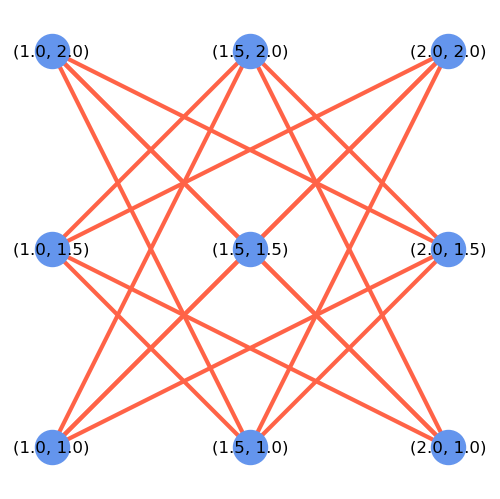

In [155]:
hestus.plot(to_delete)

Delete spurious edges

In [156]:
FG.remove_edges_from(to_delete)

New graph

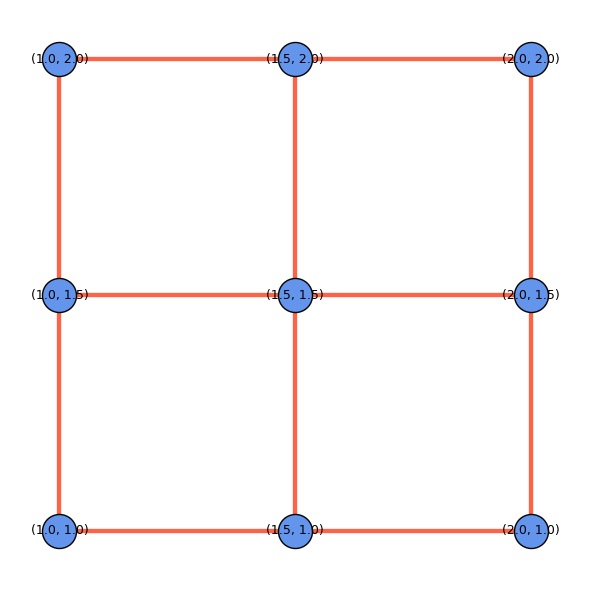

In [157]:
hestus.plot_graph(FG)

### Issue: some edges cross more than one node

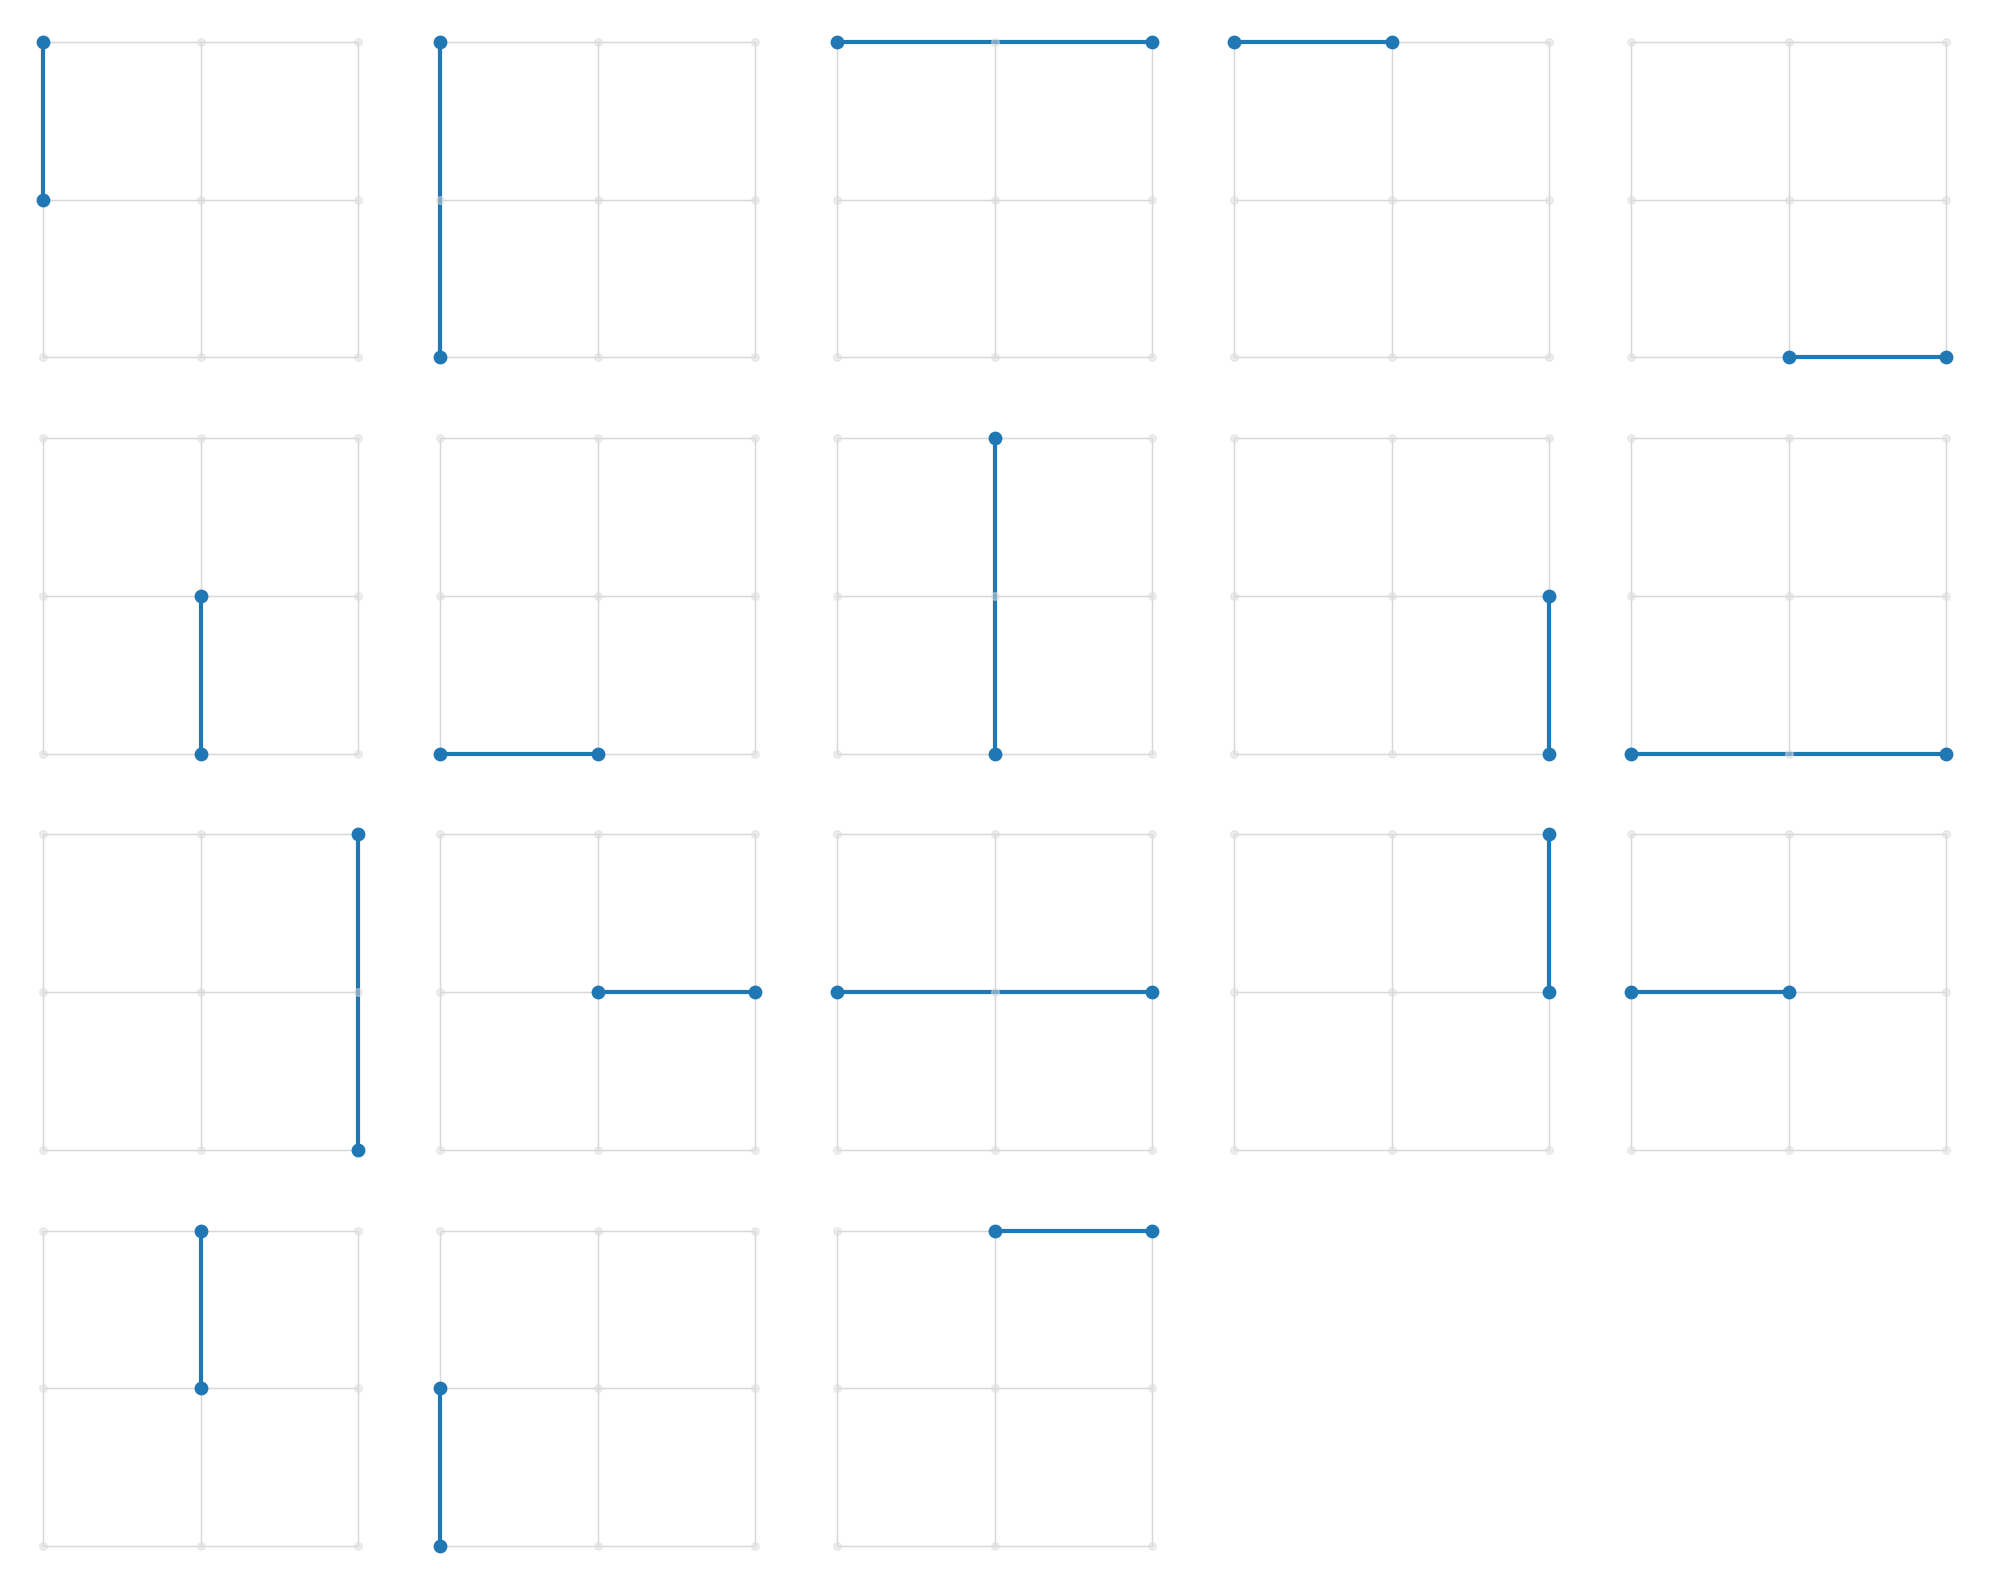

In [171]:
edges = list(FG.edges())
n      = len(edges)
cols   = 5                       # adjust to taste
rows   = -(-n // cols)           # ceiling division
pos = {p: p for p in FG.nodes()}          # node ‚Üí (x, y)

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

for ax, (u, v) in zip(axes.ravel(), edges):
    nx.draw_networkx_edges(FG, pos, ax=ax, width=1, edge_color="#cccccc", alpha=0.5)
    nx.draw_networkx_nodes(FG, pos, ax=ax, node_size=30, node_color="#dddddd", alpha=0.5)
    nx.draw_networkx_edges(FG, pos, ax=ax, edgelist=[(u, v)], width=3, edge_color="tab:blue")
    nx.draw_networkx_nodes(FG, pos, ax=ax, nodelist=[u, v], node_size=80, node_color="tab:blue")
    ax.set_aspect("equal"); ax.set_axis_off()

# turn off any leftover empty axes
for ax in axes.ravel()[n:]:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

Almost there. I need now to remove edges that cross over more than two nodes.

In [192]:
def is_on_segment(p, seg, *, eps=1e-9):
    """
    True if point `p` lies on the **closed** segment `seg`.
    Parameters
    ----------
    p : tuple 
    seg : ((x1, y1), (x2, y2)) tuple   ‚Äì segment endpoints
    eps     : tolerance for floating-point colinearity test
    """
    px, py = p
    (ax, ay), (bx, by) = seg
    
    # 1. Colinearity test   |(b-a) x (p-a)| == 0
    cross = (bx - ax) * (py - ay) - (by - ay) * (px - ax)
    if abs(cross) > eps:
        return False

    # 2. Projection test  0 ‚â§ (p-a)¬∑(b-a) ‚â§ |b-a|¬≤
    dot = (px - ax) * (bx - ax) + (py - ay) * (by - ay)
    if dot < 0:
        return False

    squared_len = (bx - ax) ** 2 + (by - ay) ** 2
    if dot > squared_len:
        return False

    return True

In [173]:
FG.edges()

EdgeView([((1.0, 2.0), (1.0, 1.5)), ((1.0, 2.0), (1.0, 1.0)), ((1.0, 2.0), (2.0, 2.0)), ((1.0, 2.0), (1.5, 2.0)), ((1.5, 1.0), (2.0, 1.0)), ((1.5, 1.0), (1.5, 1.5)), ((1.5, 1.0), (1.0, 1.0)), ((1.5, 1.0), (1.5, 2.0)), ((2.0, 1.0), (2.0, 1.5)), ((2.0, 1.0), (1.0, 1.0)), ((2.0, 1.0), (2.0, 2.0)), ((2.0, 1.5), (1.5, 1.5)), ((2.0, 1.5), (1.0, 1.5)), ((2.0, 1.5), (2.0, 2.0)), ((1.5, 1.5), (1.0, 1.5)), ((1.5, 1.5), (1.5, 2.0)), ((1.0, 1.5), (1.0, 1.0)), ((2.0, 2.0), (1.5, 2.0))])

In [193]:
is_on_segment((1.5,2), ((1.0, 2.0), (2.0,2.0)))

True

Keep only edges that cross only two nodes

Build a list of edges to delete

In [255]:
# set with connections between nodes
to_delete=set()

for edge in FG.edges():
    # if the edge under consideration crosses more than two nodes, discard it 
    survive=True
    for node in FG.nodes():
        if node!=edge[0] and node!=edge[1]:
            if is_on_segment(node,edge):
                survive=False             

    if not survive:
        to_delete.add(edge)

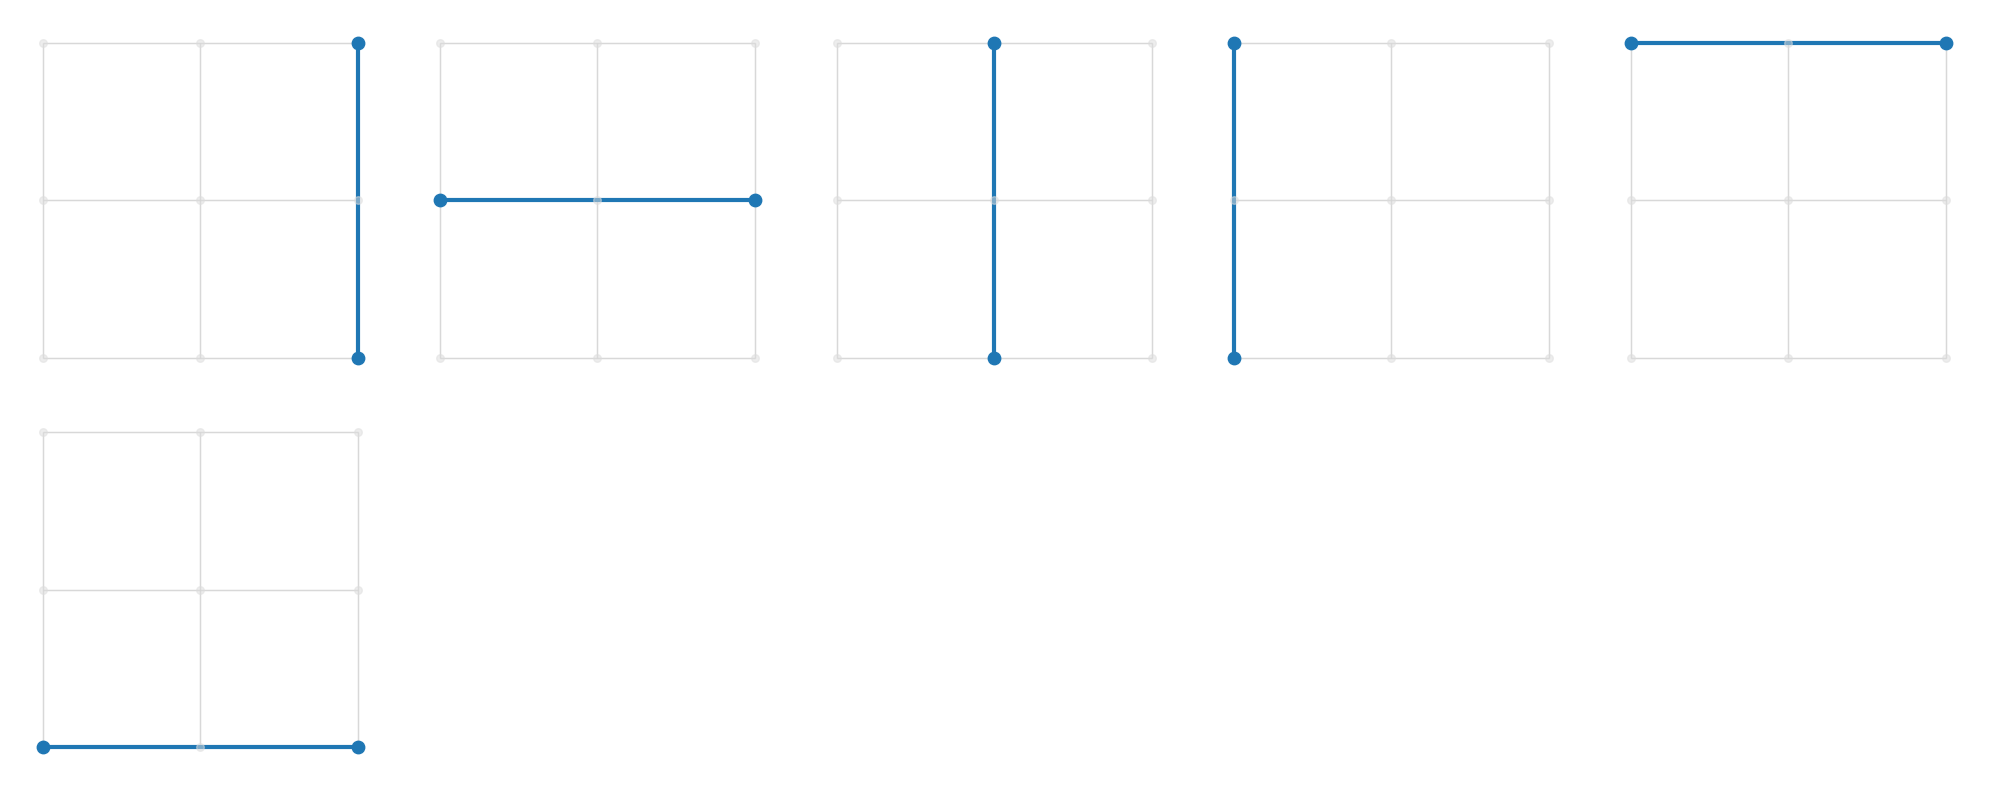

In [197]:
edges = list(to_delete)
n      = len(edges)
cols   = 5                       # adjust to taste
rows   = -(-n // cols)           # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

for ax, (u, v) in zip(axes.ravel(), edges):
    nx.draw_networkx_edges(FG, pos, ax=ax, width=1, edge_color="#cccccc", alpha=0.5)
    nx.draw_networkx_nodes(FG, pos, ax=ax, node_size=30, node_color="#dddddd", alpha=0.5)
    nx.draw_networkx_edges(FG, pos, ax=ax, edgelist=[(u, v)], width=3, edge_color="tab:blue")
    nx.draw_networkx_nodes(FG, pos, ax=ax, nodelist=[u, v], node_size=80, node_color="tab:blue")
    ax.set_aspect("equal"); ax.set_axis_off()

# turn off any leftover empty axes
for ax in axes.ravel()[n:]:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

Delete spurious edges

In [198]:
FG.remove_edges_from(to_delete)

What remains

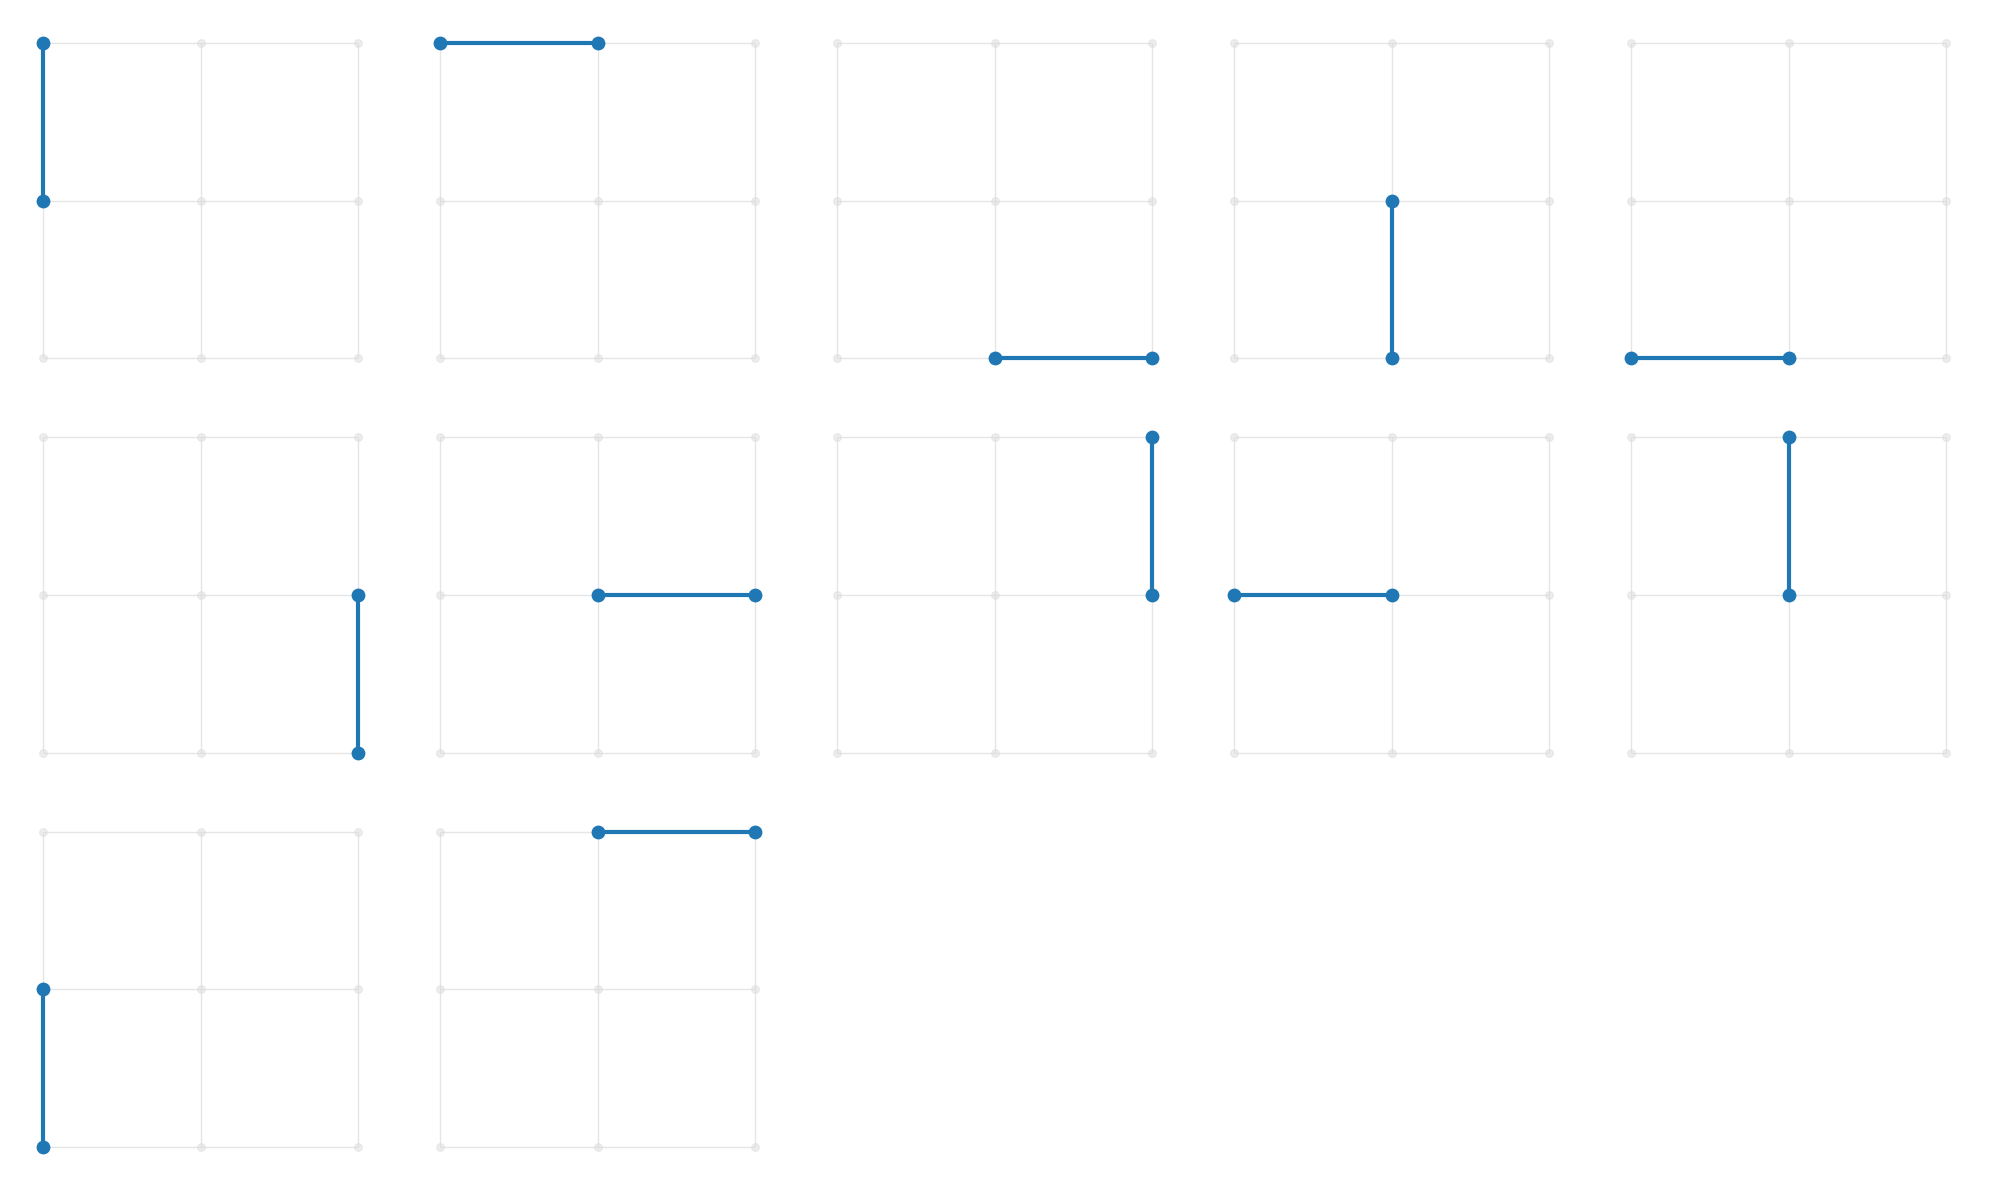

In [199]:
edges = list(FG.edges())
n      = len(edges)
cols   = 5                       # adjust to taste
rows   = -(-n // cols)           # ceiling division

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

for ax, (u, v) in zip(axes.ravel(), edges):
    nx.draw_networkx_edges(FG, pos, ax=ax, width=1, edge_color="#cccccc", alpha=0.5)
    nx.draw_networkx_nodes(FG, pos, ax=ax, node_size=30, node_color="#dddddd", alpha=0.5)
    nx.draw_networkx_edges(FG, pos, ax=ax, edgelist=[(u, v)], width=3, edge_color="tab:blue")
    nx.draw_networkx_nodes(FG, pos, ax=ax, nodelist=[u, v], node_size=80, node_color="tab:blue")
    ax.set_aspect("equal"); ax.set_axis_off()

# turn off any leftover empty axes
for ax in axes.ravel()[n:]:
    ax.set_axis_off()

plt.tight_layout()
plt.show()

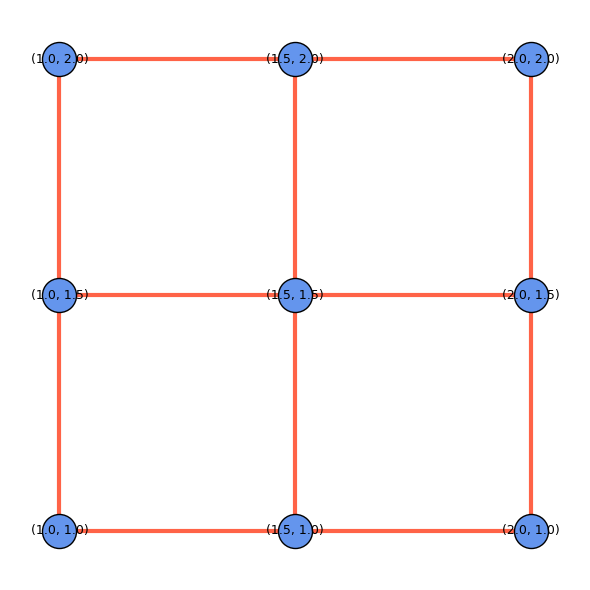

In [200]:
hestus.plot_graph(FG)

## (3) Identify closed regions

Plots identified cycles

In [209]:
def plot_cycles(cycles, cols=4):
    n = len(cycles)
    rows = -(-n // cols)           # ceiling division
    fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))

    for ax, cycle in zip(axes.ravel(), cycles):
        cycle_edges = list(zip(cycle, cycle[1:] + cycle[:1]))
        nx.draw_networkx_edges(FG, pos, ax=ax, width=1, edge_color="#cccccc", alpha=0.6)
        nx.draw_networkx_nodes(FG, pos, ax=ax, node_size=30, node_color="#dddddd", alpha=0.6)
        nx.draw_networkx_edges(FG, pos, ax=ax, edgelist=cycle_edges, width=3, edge_color="tab:red")
        nx.draw_networkx_nodes(FG, pos, ax=ax, nodelist=cycle, node_size=80, node_color="tab:red")
        ax.set_aspect("equal"); ax.set_axis_off()

    plt.tight_layout()
    plt.show()

In [212]:
len(FG.edges())

12

Default algorithm sucks ü§î

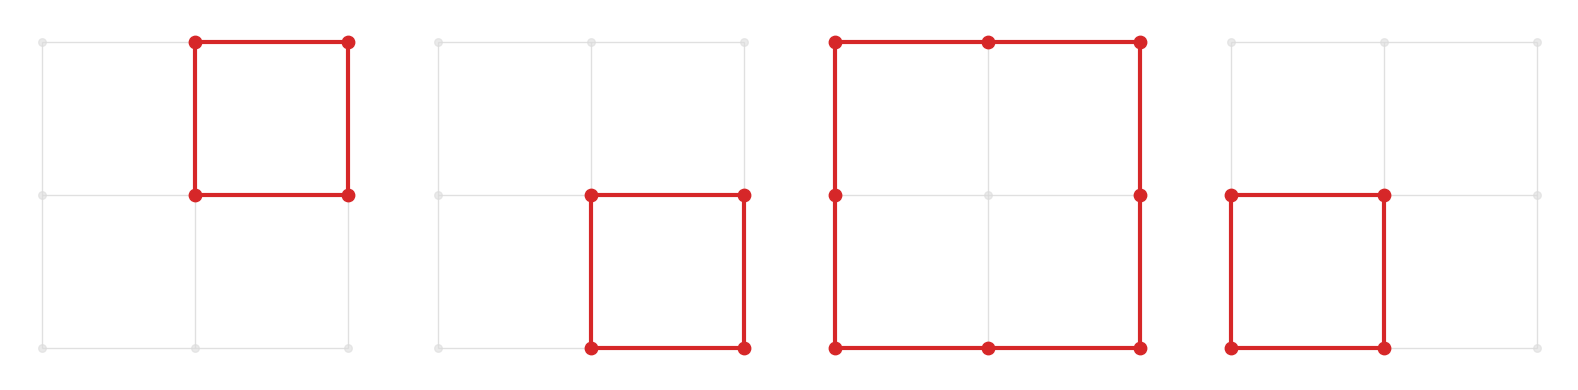

In [215]:
plot_cycles(nx.cycle_basis(FG))

Alternative (niiiice! üòÅ): computes cycles of minimal length

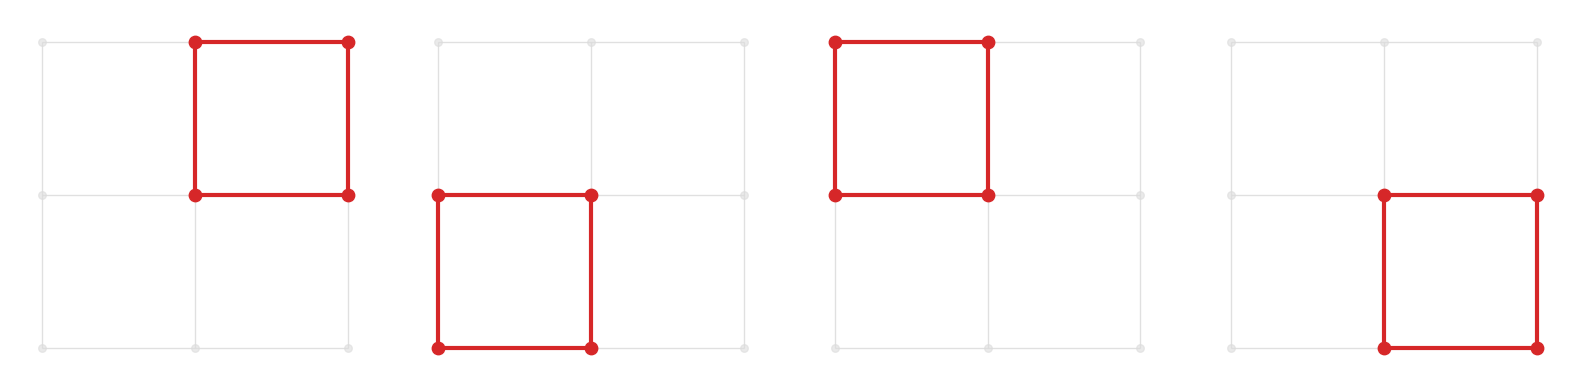

In [216]:
plot_cycles(nx.minimum_cycle_basis(FG))

## (4) Get perimeters of small cycles and compute the final answer

In [217]:
min_cycles=nx.minimum_cycle_basis(FG)

In [220]:
min_cycles

[[(2.0, 2.0), (1.5, 2.0), (1.5, 1.5), (2.0, 1.5)],
 [(1.0, 1.0), (1.0, 1.5), (1.5, 1.5), (1.5, 1.0)],
 [(1.5, 2.0), (1.5, 1.5), (1.0, 1.5), (1.0, 2.0)],
 [(1.5, 1.5), (2.0, 1.5), (2.0, 1.0), (1.5, 1.0)]]

For convenience for the calculations that follow, repeat the last point at the end

In [230]:
for sublist in min_cycles:
    sublist.append(sublist[0])

min_cycles

[[(2.0, 2.0), (1.5, 2.0), (1.5, 1.5), (2.0, 1.5), (2.0, 2.0)],
 [(1.0, 1.0), (1.0, 1.5), (1.5, 1.5), (1.5, 1.0), (1.0, 1.0)],
 [(1.5, 2.0), (1.5, 1.5), (1.0, 1.5), (1.0, 2.0), (1.5, 2.0)],
 [(1.5, 1.5), (2.0, 1.5), (2.0, 1.0), (1.5, 1.0), (1.5, 1.5)]]

In [252]:
distance=lambda p1,p2: math.sqrt((p1[0]-p2[0])**2+(p1[1]-p2[1])**2)

In [253]:
def final_answer(cycles):
    perimeters=[]
    
    for cycle in cycles:
        perimeter=0
        sides=len(cycle)-1
        
        for i in range(sides):
            perimeter+=distance(cycle[i],cycle[i+1])

        perimeters.append(perimeter)

    return np.prod(perimeters)

In [254]:
final_answer(min_cycles)

16.0